This was an individual project and I did everything in it. 

For task 1, I used Claude to help explain how SIFT works and what the implementation should look like.

# Task 1: Localize a Hidden Object in the Scene 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

template = cv2.imread('auburn.jpeg')
scene = cv2.imread('Part1_scene.png')

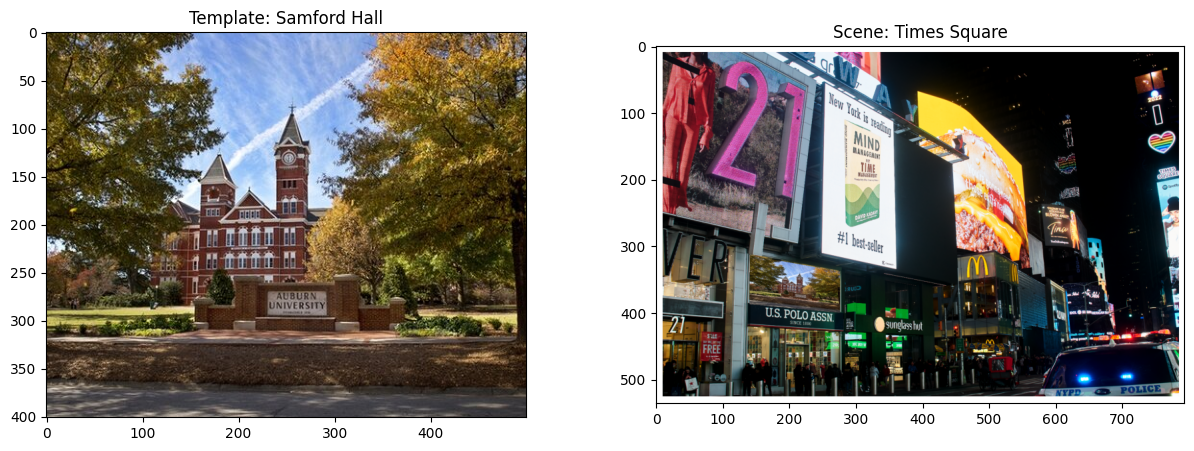

In [ ]:
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title('Template: Samford Hall')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
plt.title('Scene: Times Square')
plt.show()

## Detect Keypoints

Each circle is the location of some local extrema. The line from the circle shows which direction the gradient is coming from. The size of the circle is how large the keypoint is. For example, some fine grained visual detail will have a small circle, but some coarse detail will have a big circle.

Keypoints in template: 2085
Keypoints in scene: 3135


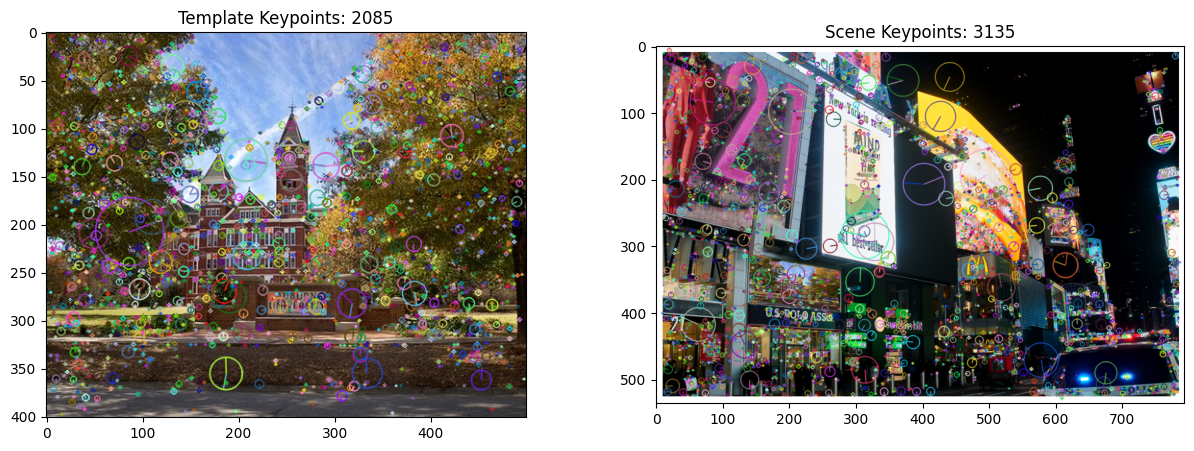

In [12]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(template_gray, None)
kp2, des2 = sift.detectAndCompute(scene_gray, None)

print(f"Keypoints in template: {len(kp1)}")
print(f"Keypoints in scene: {len(kp2)}")

# Optional: Visualize keypoints
img_kp1 = cv2.drawKeypoints(template, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp2 = cv2.drawKeypoints(scene, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_kp1, cv2.COLOR_BGR2RGB))
plt.title(f'Template Keypoints: {len(kp1)}')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_kp2, cv2.COLOR_BGR2RGB))
plt.title(f'Scene Keypoints: {len(kp2)}')
plt.show()

## Brute force matcher

`NORM_L2` (euclidian distance) is the distance metric we are using. A smaller distance indicates a closer match.

In this code we are comparing every descriptor to every other descriptor in the original image. Then, we are only keeping the `k` closest matches. 

In [14]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

print(f"Total initial matches: {len(matches)}")

Total initial matches: 2085


## FLANN

Another way to compare the descriptors is to use more sophisticated data structures through methods like FLANN. This ensures that we don't have to compare _every_ descriptor against every other descriptor. This is much faster, but it can give potentially worse results. Therefore, I am just using the brute force method.

In [ ]:
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# search_params = dict(checks=50)

# flann = cv2.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(des1, des2, k=2)

## Lowe's Ratio Test

We want to filter down to only confident matches. For each template feature,  we find the best match and second-best match in the scene image. We then compare these two candidates: if the best match is significantly better than the second-best match (ratio < 0.75), we keep it because the match is distinctive. If the best and second-best are too similar (ratio >= 0.75), we discard it because the match is ambiguous.

Good matches after ratio test: 23


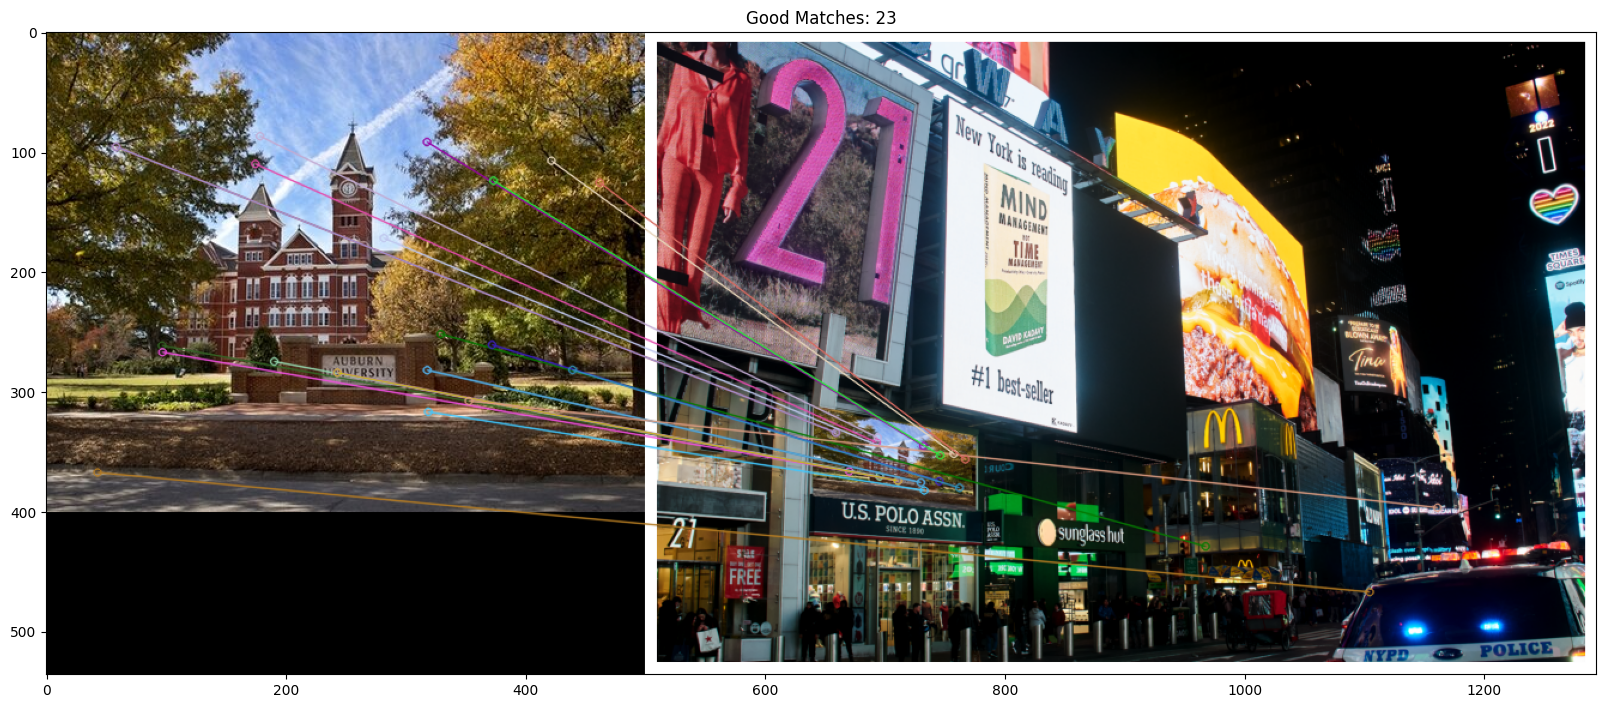

In [15]:
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Good matches after ratio test: {len(good_matches)}")

img_matches = cv2.drawMatches(
    template, kp1, 
    scene, kp2, 
    good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f'Good Matches: {len(good_matches)}')
plt.show()

## Homography

We want a 3×3 matrix that describes how to transform points from one image to another. RANSAC helps us find the best matrix for this while ignoring outliars.

It randomly picks 4 matches and then creates the homography matrix H from it. Then it tests how many matches agree with H and how many disagree.

In [20]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute homography using RANSAC
# H = 3x3 transformation matrix
# mask = inliers (1) vs outliers (0)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

matches_mask = mask.ravel().tolist()
inliers = sum(matches_mask)

print(f"Homography computed with {inliers} inliers out of {len(good_matches)} matches")
print(f"Homography matrix:\n{H}")

Homography computed with 20 inliers out of 23 matches
Homography matrix:
[[ 3.49604351e-01 -6.07896645e-04  1.41584718e+02]
 [ 1.42335259e-01  1.83667722e-01  3.14592983e+02]
 [ 2.83008126e-04  1.23220310e-05  1.00000000e+00]]


## Perspective Shift

Now that we have the homography matrix, we need to visualize the results. We get the bounding box data of the original image of Samford Hall, and then multipl it with H to transform it to the location in the new image.

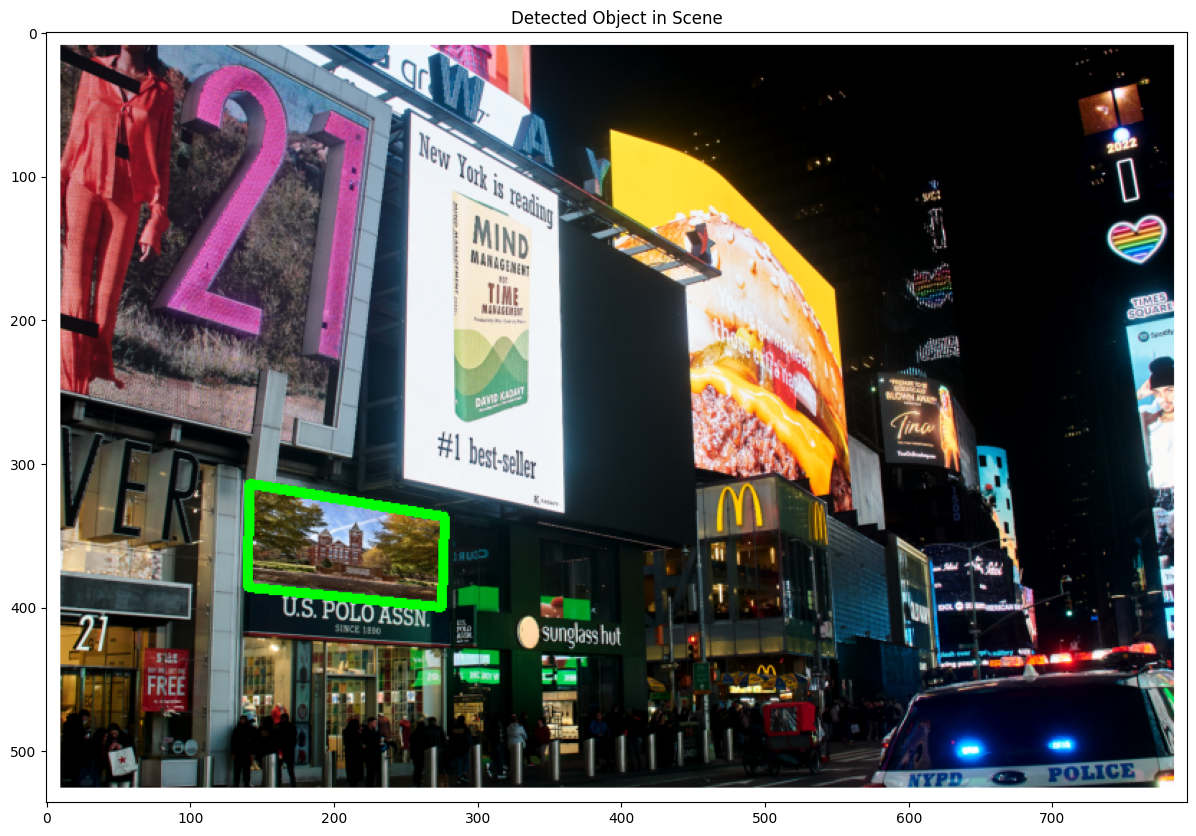

Result saved as 'result_detected.png'


In [22]:
h, w = template_gray.shape

pts = np.float32([
    [0, 0],           # Top-left
    [w, 0],           # Top-right
    [w, h],           # Bottom-right
    [0, h]            # Bottom-left
]).reshape(-1, 1, 2)

# Transform corners using homography
dst = cv2.perspectiveTransform(pts, H)

# Draw polygon on scene
scene_with_box = scene.copy()
scene_with_box = cv2.polylines(
    scene_with_box, 
    [np.int32(dst)], 
    isClosed=True, 
    color=(0, 255, 0),
    thickness=5
)

# Display result
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(scene_with_box, cv2.COLOR_BGR2RGB))
plt.title('Detected Object in Scene')
plt.show()

# Save result
cv2.imwrite('result_detected.png', scene_with_box)
print("Result saved as 'result_detected.png'")

# Task 2